# Botnet Detection with Machine Learning
This notebook walks through a full ML pipeline for classifying network traffic as **BENIGN** or **Bot**.
- Includes 5 models, hyperparameter tuning, and a voting classifier.
- Visualizations and performance metrics are used throughout.

**Note:** Dataset is not included due to size. Please upload it manually and update file path in code.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some visual settings
sns.set(style="whitegrid")
%matplotlib inline

# Load the dataset
df = pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")

# Preview the shape
print("Shape of dataset:", df.shape)

# Show first 5 rows
df.head()


Shape of dataset: (191033, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [3]:
df.columns = df.columns.str.strip()#cleaning coloumns


In [4]:
print(df.columns.tolist())  # confirm 'Label' is now clean


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [5]:
df['Label'].value_counts()


Label
BENIGN    189067
Bot         1966
Name: count, dtype: int64

In [6]:
import numpy as np
# Drop inf and nan values to ensure system doesnt crash
print("Total Null values:", df.isnull().sum().sum())
print("Total Infinite values:", np.isinf(df.select_dtypes(include=[np.number])).sum().sum())


Total Null values: 28
Total Infinite values: 216


In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [8]:
print("After replacement — Null values:", df.isnull().sum().sum())


After replacement — Null values: 244


In [9]:
df.dropna(inplace=True)
print("Shape after cleaning:", df.shape)


Shape after cleaning: (190911, 79)


In [10]:
# Separate Features and Labels
X = df.drop(columns=['Label'])
y = df['Label']
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)  # BENIGN = 0, Bot = 1
# Split dataset to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
# Scaling the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
##helper function
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)#train the model to learn from the input data to find patterns
    y_pred = model.predict(X_test)#use the trained model to predict the label on the test data

    print(f"\n📊 {name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'Bot']))#Displays precision, recall, f1-score, and support.

    cm = confusion_matrix(y_test, y_pred)#confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['BENIGN', 'Bot'],
                yticklabels=['BENIGN', 'Bot'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     37792
         Bot       0.80      0.61      0.69       391

    accuracy                           0.99     38183
   macro avg       0.90      0.80      0.84     38183
weighted avg       0.99      0.99      0.99     38183



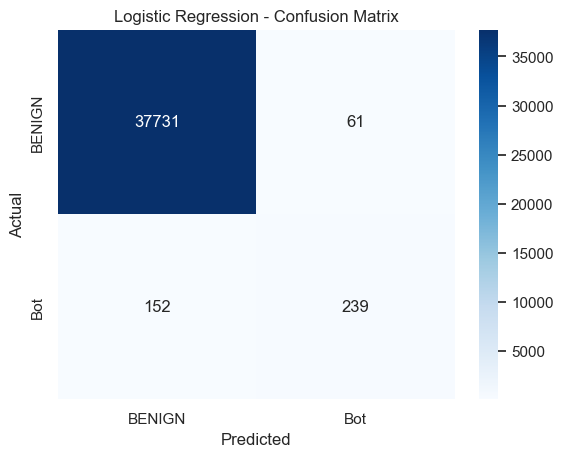

In [12]:
# Logistic regression
lr = LogisticRegression()
evaluate_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)



📊 Random Forest Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     37792
         Bot       0.99      0.96      0.98       391

    accuracy                           1.00     38183
   macro avg       1.00      0.98      0.99     38183
weighted avg       1.00      1.00      1.00     38183



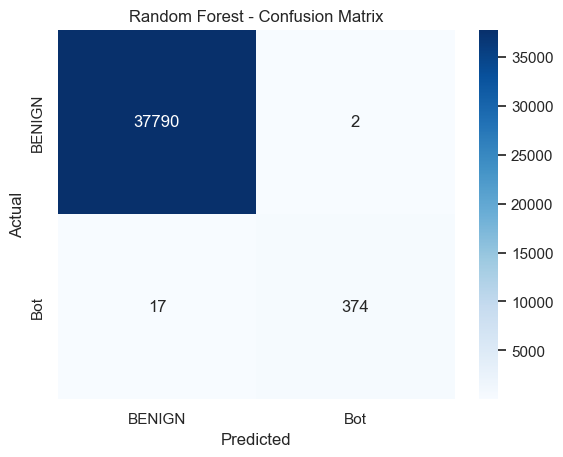

In [13]:
# Random forest
rf = RandomForestClassifier()
evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)



📊 Support Vector Machine Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     37792
         Bot       0.91      0.61      0.73       391

    accuracy                           1.00     38183
   macro avg       0.95      0.81      0.86     38183
weighted avg       1.00      1.00      0.99     38183



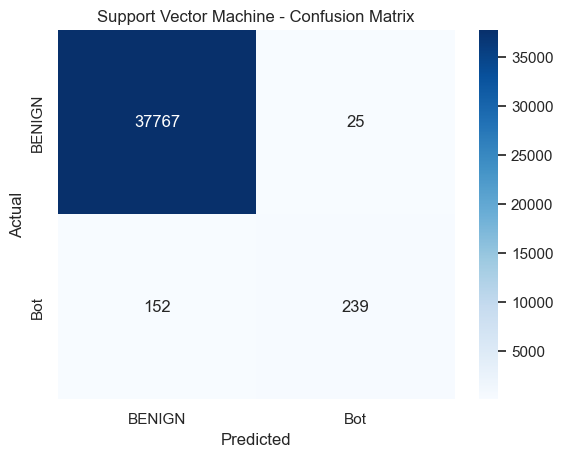

In [14]:
# Support Vector Machine (SVM)
svm = SVC()
evaluate_model("Support Vector Machine", svm, X_train, y_train, X_test, y_test)



📊 XGBoost Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     37792
         Bot       0.99      0.99      0.99       391

    accuracy                           1.00     38183
   macro avg       0.99      0.99      0.99     38183
weighted avg       1.00      1.00      1.00     38183



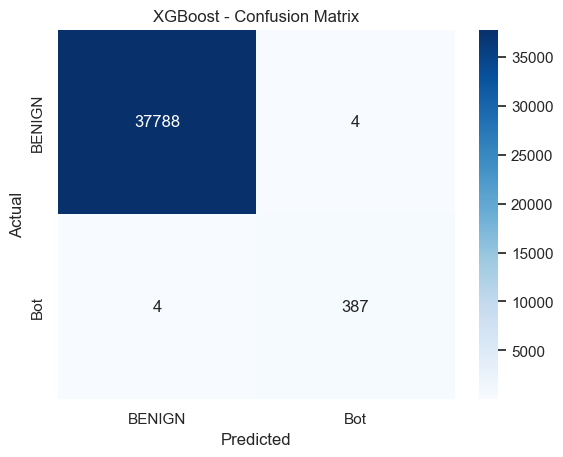

In [15]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model("XGBoost", xgb, X_train, y_train, X_test, y_test)



📊 MLP (Neural Network) Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     37792
         Bot       0.94      0.71      0.81       391

    accuracy                           1.00     38183
   macro avg       0.97      0.85      0.90     38183
weighted avg       1.00      1.00      1.00     38183



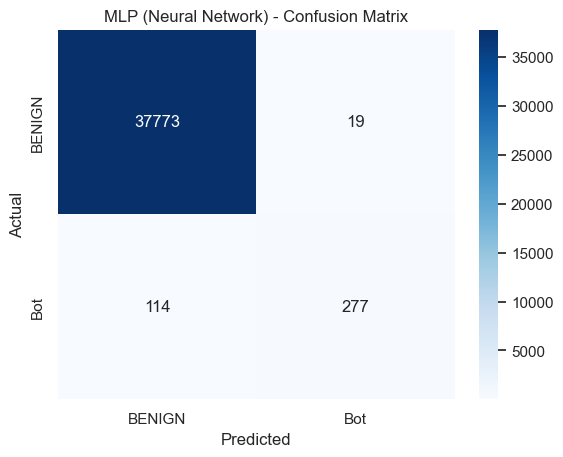

In [16]:
# Multilayer Perceptron (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=300)
evaluate_model("MLP (Neural Network)", mlp, X_train, y_train, X_test, y_test)


In [17]:
# To store i tabular form for comparisons
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

def evaluate_and_store(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label= 1)
    rec = recall_score(y_test, y_pred, pos_label= 1)
    f1 = f1_score(y_test, y_pred, pos_label= 1)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    print(f"\n{name} evaluation complete.")


In [18]:
# Clear previous results
results = []

evaluate_and_store("Logistic Regression", LogisticRegression(), X_train, y_train, X_test, y_test)
evaluate_and_store("Random Forest", RandomForestClassifier(), X_train, y_train, X_test, y_test)
evaluate_and_store("SVM", SVC(), X_train, y_train, X_test, y_test)
evaluate_and_store("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_train, y_train, X_test, y_test)
evaluate_and_store("MLP", MLPClassifier(hidden_layer_sizes=(100,100), max_iter=300), X_train, y_train, X_test, y_test)



Logistic Regression evaluation complete.

Random Forest evaluation complete.

SVM evaluation complete.

XGBoost evaluation complete.

MLP evaluation complete.


In [19]:
performance_df = pd.DataFrame(results)
performance_df.set_index('Model', inplace=True)
performance_df.round(4)  # round for cleaner display


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.9944,0.7967,0.6113,0.6918
Random Forest,0.9995,0.9947,0.9565,0.9752
SVM,0.9954,0.9053,0.6113,0.7298
XGBoost,0.9998,0.9898,0.9898,0.9898
MLP,0.9966,0.9677,0.6905,0.8060


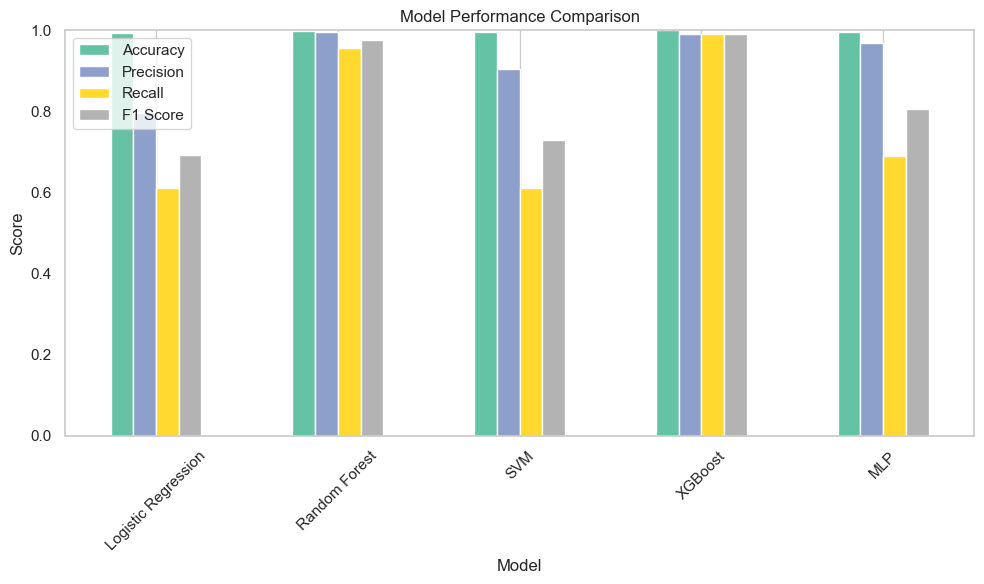

In [20]:
performance_df.plot(kind='bar', figsize=(10,6), colormap='Set2', ylim=(0, 1))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [21]:
# Hyperparameter tuning for random forest using Grid Search with Cross-Validation
rf_params = {
    'n_estimators': [100, 200],#number of trees in the forest
    'max_depth': [10, 20, None],# maximum depth of the tree
    'min_samples_split': [2, 5]#minimum number of samples used to split a node
}
# 12 combinations to try
# Using 3 fold cv to estimate performance
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3,
                       scoring='f1'#scored using f1 logs
                       ,verbose=1,#prints progress logs
                       n_jobs=-1 #uses all CPU cores to speed up training
                      )
grid_rf.fit(X_train, y_train)

print("🔍 Best parameters (RF):", grid_rf.best_params_)
evaluate_and_store("Random Forest (Tuned)", grid_rf.best_estimator_, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
🔍 Best parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest (Tuned) evaluation complete.


In [22]:
# Hyperparameter tuning for xg boost

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1] #How quickly the model learns
}

grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss'), xgb_params, cv=3, 
                        scoring='f1'
                        , verbose=1,
                        n_jobs=-1)
grid_xgb.fit(X_train, y_train)#trains 24 models

print("🔍 Best parameters (XGB):", grid_xgb.best_params_)
evaluate_and_store("XGBoost (Tuned)", grid_xgb.best_estimator_, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 Best parameters (XGB): {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

XGBoost (Tuned) evaluation complete.


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Define parameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],#Regularization strength (inverse; lower = stronger regularization)
        'penalty': ['l2'],#Only 'l2' is supported by both solvers
        'solver': ['liblinear', 'lbfgs']# Optimization algorithm to use
    },
    "MLP": {
        'hidden_layer_sizes': [(50,), (100,), (100, 100)],#Number of neurons in each layer
        'activation': ['relu', 'tanh'],,#Activation function for neurons
        'solver': ['adam'],#Optimizer (usually 'adam' for performance)
        'max_iter': [300, 500]#Max training iterations
    }
}

# Map model names to instances
models = {
    "Logistic Regression": LogisticRegression(),
    "MLP": MLPClassifier()
}

# Create empty variables to hold each tuned grid object
grid_lr = None
grid_mlp = None

# Loop through models for tuning and evaluation
for name in models:
    print(f"\n🔧 Tuning {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    print(f"✅ Best parameters for {name}: {grid.best_params_}")
    evaluate_and_store(f"{name} (Tuned)", grid.best_estimator_, X_train, y_train, X_test, y_test)

# Store the grid object for later use
    if name == "Logistic Regression":
        grid_lr = grid
    elif name == "MLP":
        grid_mlp = grid


SyntaxError: invalid syntax (3976519448.py, line 14)

In [ ]:
# Plot comparison
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df['Base Model'] = df['Model'].apply(lambda x: x.replace(" (Tuned)", ""))
df = df.sort_values(by='Base Model')

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Base Model', y='F1 Score', hue='Model', palette='Set2')
plt.title("🔍 F1 Score Comparison: Normal vs Tuned Models")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title="Model Version")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

# Step 1: Create the tuned models
xgb_tuned = grid_xgb.best_estimator_
mlp_tuned = grid_mlp.best_estimator_
lr_tuned = grid_lr.best_estimator_

# Step 2: Create a voting classifier with these models
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_tuned),
        ('mlp', mlp_tuned),
        ('lr', lr_tuned)
    ],
    voting='soft'  # soft uses predicted probabilities; better if models output probabilities
)

# Step 3: Fit the ensemble model
voting_clf.fit(X_train, y_train)

# Step 4: Evaluate the ensemble model using your custom function
evaluate_and_store("Voting Classifier (XGB + MLP + LR)", voting_clf, X_train, y_train, X_test, y_test)


In [ ]:
import joblib

# Save the model and scaler after training
joblib.dump(voting_clf, "voting_classifier_model.pkl")
joblib.dump(scaler, "scaler.pkl")
